# Machine Learning Model Predictions
This notebook walks the user through the process of using GBDX Notebooks and task deploy to make predictions on a pre-trained ML model. The model used in this example was generated using [pixel-decoder](https://github.com/Geoyi/pixel-decoder), an open source semantic segmentation library. The model was trained using OSM building footprints and TMS Imagery on the western coast of Africa. 

### About Task Deploy
A GBDX task is a process that performs a specific action on its inputs and generates a set of outputs. The user defines a set of inputs in a notebook, then the task follows the rest of the code in the notebook and generates a result, which can be saved to an s3 bucket. Tasks are particularly useful for performing analysis on larger scales that a notebook kernel alone cannot handle.  

### About the model
pixel-decoder is an open source library that allows users to train and store models, then perform predictions to get results with said model. pixel-decoder generates semantic segmentation models, and is based off of ResNet, a popular and accurate neural network. If you would like to learn more about either of these terms, please see [this link](https://medium.com/nanonets/how-to-do-image-segmentation-using-deep-learning-c673cc5862ef) on semantic segmentation and [this link](https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624) on ResNet.

In the initial version of pixel-decoder ([this github repository](https://github.com/Geoyi/pixel-decoder)), the library trains models off of images generated using [label-maker](https://github.com/developmentseed/label-maker), a library that generates ML training data from Open Street Map (OSM) vectors and MapBox image data. Because [Vector Services](https://gbdxdocs.digitalglobe.com/docs/vector-services-overview) already has OSM data, and MapBox's imagery service runs off of DG TMS (Tile Map Service) Imagery, I modified the repository slightly to run off of tools available on GBDX instead of label-maker. You can see my version of the repository [here](https://github.com/chloe-hampton/pixel-decoder). If you are unfamilar with Vector Services or TMS Imagery (or any of the other image classes used in GBDX) check out [this link](https://gbdxdocs.digitalglobe.com/docs/vector-services-overview), [and this one](https://gbdxtools.readthedocs.io/en/latest/api_reference.html#tmsimage). 

### Step 0: Package installation and imports
Note: Packages must be installed in the order shown below.

In [ ]:
# !pip install git+https://github.com/chloe-hampton/pixel-decoder.git
# !pip install tensorflow
# !pip install opencv-python
# !pip install keras==2.2.0 --upgrade
# !pip install dask==0.18.0 --upgrade

In [11]:
import numpy.core._methods
import numpy.lib.format
#from pixel_decoder.train import train
#from pixel_decoder.predict import predict
from gbdxtools import Interface, TmsImage, CatalogImage
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box, shape
from shapely.ops import cascaded_union, transform
import dask.array as da
# import modules for accessing data on s3
import boto3
from botocore.exceptions import ClientError
import json
from gbdxtools.task import env
from gbdxtools import Interface
from functools import partial
import pyproj
gbdx=Interface()
from os import path, listdir, mkdir
#import cv2

## Step 1: Define input variables
The end goal of this tutorial is to deploy and run this notebook as a task. In order to do this, we need to declare the task input parameters using the task specific `env.inputs.get()` syntax.

This task takes two input variables:

* `bbox`: The bounding box of area we're interested in running model predictions on
* `data_path`: The location of the model in our gbd-customer s3 bucket. 

As mentioned in the introduction, this model was trained using data from DG's TMS (Tiled Map Service) imagery, so we'll perform predictions using the same image class. TMS images do not take a catalog ID--they only take an area of interest, or bounding box. 

In [2]:
bbox = env.inputs.get('bbox', '-0.23126408457756045, 5.5390799018575345, -0.10025024414062501, 5.614549715277301')
tms = TmsImage(zoom = 18)
tms_region = tms.aoi(bbox = map(float, bbox.split(",")))
bbox_geom = box(*[float(b) for b in bbox.split(",")])

In [3]:
data_path = env.inputs.get('data_path', 'resnet_unet_weights.h5')
gbdx.s3.download(data_path)
open(data_path)


<_io.TextIOWrapper name='resnet_unet_weights.h5' mode='r' encoding='ANSI_X3.4-1968'>

## Step 2: Gather OSM data for the area of interest
In addition to gathering imagery, we can also use the `bbox` variable to query vector services for OSM data. Though not always necessary, having OSM data can be a reliable source for manually validating your results. It's particularly useful for this model, because the model was trained using OSM footprints. 

Querying vector services is somewhat obscure. To best understand the syntax of the code below, take a look at [this documentation](https://gbdxtools.readthedocs.io/en/latest/vector_service.html). 

In [4]:
osm_data = gbdx.vectors.query(bbox_geom.wkt, query = "item_type:* AND ingest_source:OSM", ##look for OSM items in our AOI
                              index = "vector-osm-*", count = 1E6) ##limit the object count to one million
print("{} features found in search area".format(len(osm_data))) ##verify that there are actually features here
osm_buildings = []
for i,a in enumerate(osm_data):
    if osm_data[i]['properties']['item_type'] == ['Building']: ##find all of the buildings from search results
        osm_buildings.append(shape(osm_data[i]['geometry'])) ##save just the building geometries

25646 features found in search area


## Step 3: Reproject OSM data
OSM data uses a different coordinate system than the TMS imagery, so in order to use it, the data needs to be reprojected into the correct coordinate space. To do this we'll use [pyproj](https://pypi.org/project/pyproj/).

In [5]:
reproj = partial(pyproj.transform, pyproj.Proj(init = "EPSG:4326"), pyproj.Proj(init = "EPSG:3857"))
buildings_transformed = [transform(reproj, i) for i in osm_buildings]

## Step 4: Tile area of interest
In order to make predictions, the image data needs to be tiled up into 256x256 squares.
To tile the imagery, we'll iterate over a generator created using `window_cover` an image tiling method in `gbdxtools`. The docs for this method can be found [here](https://gbdxtools.readthedocs.io/en/latest/api_reference.html#gbdxtools.images.meta.CatalogImage.window_cover).

_Why do we need to do this?_
Image tiling is a common convention in machine learning for a number of reasons. The biggest reason is that images are inherently 'heavy', meaning they require a lot of computation power. Trying to run a model over an entire area of interest at once is simply innefficient. For this model, we specifically picked squares of size 256x256 because ResNet, the backbone of pixel-decoder, is a CNN, or convolutional neural net. The convolutions for ResNet are done in factors of 2048, so the model works best with square tiles that are factors of 2048. If you're interested in the math/significance behind tiling for CNNs, check out [this article](https://medium.com/data-from-the-trenches/object-detection-with-deep-learning-on-aerial-imagery-2465078db8a9). (Note: the previous link is based off of an object detection classifier, not segmentation, but it is still a great read.) 



In [20]:
#tile images
chip_generator = tms_region.window_cover((256,256),pad=False) ##create generator
count = 0
image_chips = []
dask_chips = []
while (count < 10000): #iterate over generator to get tiles
    try:
        chip = next(chip_generator)
        image_chips.append(np.array(np.moveaxis(chip,0,-1))) #reformat data so it can be plotted
        dask_chips.append(chip) ##store the dask array because it has image meta data in it
        count = count + 1
    except StopIteration:
        break

## Step 4 (continued):
At this point, we'll also tile the OSM data into the same 256x256 chips as the imagery, then transform the tiled osm geometries into an easy-to-use rasterized mask. To figure out which building belongs in which chip, we'll use the `intersect` method from the Shapely library. The docs for this method can be found [here](http://toblerity.org/shapely/manual.html#object.intersects). To convert the data into a mask, we'll use Rasterio's `rasterize` method. See the docs [here](https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html#rasterio.features.rasterize). 

In [21]:
#function to mask osm data
from rasterio.features import rasterize
def mask(shps,aoi):
    size_y,size_x = 256, 256
    mask=rasterize(shapes = shps,out_shape = (size_y,size_x),transform = aoi.affine)
    return mask

In [22]:
count = 0
predict_data = []
idx = []
while(count < len(dask_chips)):
    #tile osm data
    geoms = []
    for j, b in enumerate(buildings_transformed):
        tile_bounds = dask_chips[count].bounds ##find bounding box of the image tile
        if box(*tile_bounds).intersects(b): ## see if bounding box intersects the osm data
            geoms.append(b)
    #mask osm data
    try:
        m = mask(geoms,dask_chips[count])
        idx.append(count) ##save index for positive tiles--this comes in handy for plotting
    except:
        m = np.zeros((256,256)) #have to do this because rasterize does not take 'empty' tiles
    predict_data.append((image_chips[count], m)) 
    count = count+1 

## Step 5: Verify Tiles
Before we continue, lets take a quick look at what we have done so far. As you'll see below, the OSM data is certainly not perfect, at least for this area of interest. 

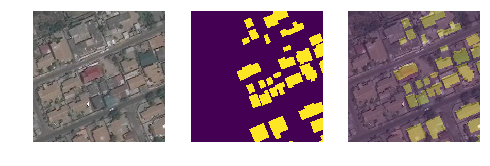

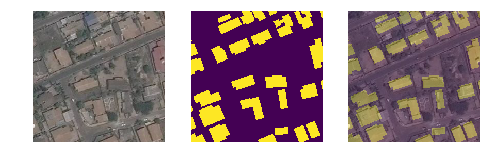

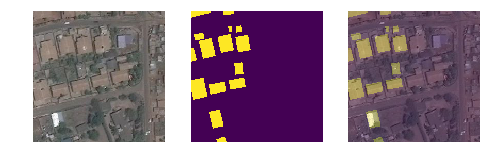

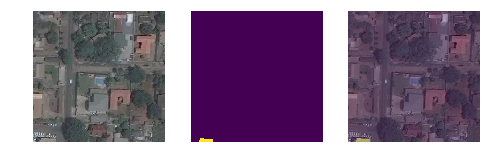

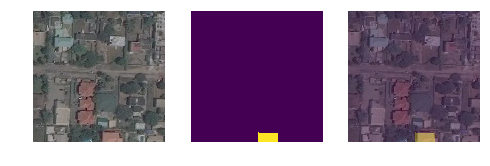

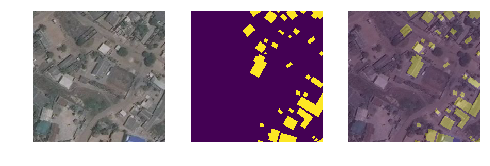

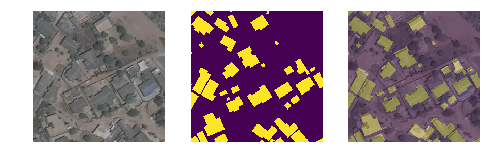

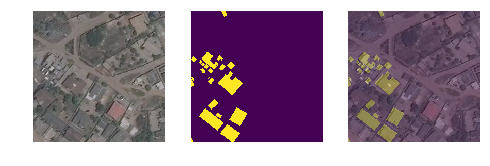

In [23]:
positive_data =[predict_data[i] for i in idx] ###take only positive integers
for i,a in enumerate(positive_data[7:15]):
    plt.figure(figsize=(8,8))
    plt.subplot(131)
    plt.imshow(a[0])
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(a[1])
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(a[0])
    plt.imshow(a[1], alpha=0.3)
    plt.axis('off')
    plt.show()
    

## Step 6: Prepare data to make predictions
Now that all of our data has been tiled up, we need to split it into testing and validation sets. Here we shuffle the data, then split it so 80% of the data gets validated, and 20% gets tested.  Its important to shuffle the data randomly 

In [ ]:
import random
def test_validate_split(data):
    random.shuffle(data)
    val_num = int(.8*len(data))
    test_num = int(.2*len(data))
    val_data = data[test_num:]
    test_data = data[0:test_num]
    return(val_data,test_data)


In [ ]:
val_data, test_data = test_validate_split(predict_data)
val_tiles = [val_data[i][0] for i, a in enumerate(val_data)]
test_tiles = [test_data[i][0] for i, a in enumerate(test_data)]
test_osm = [test_data[i][1] for i, a in enumerate(test_data)]

## Step 7: Make predictions
Now that data has been tiled and sorted, the validation and test tiles can be fed into pixel-decoder's predict method. If run as a stand-alone notebook, the results will be stored under `predictions` in the hosted notebook directory. If run as a task, the results will be stored in a user-specified s3 location. Note: `predict()` only returns results for the test dataset, *not* the validation set. The results and their corresponding image tiles will be stored as .png files.

In [ ]:
##make predictions
results_path = None #defaults to storing under ./predictions
predict(imgs_folder = val_tiles, test_folder = test_tiles, models_folder = data_path, 
        pred_folder = results_path,model_id = 'resnet_unet', origin_shape_no = 256, border_no = 32,
                    write_locally = True)

In [ ]:
#store image and OSM tiles
image_folder = 'test_images'
osm_folder = 'osm_masks'
if not path.exists(image_folder):
    mkdir(image_folder)

if not path.exists(osm_folder):
    mkdir(osm_folder)


for i,a in enumerate(test_tiles):
    cv2.imwrite(path.join(image_folder,'{}.png'.format(i)), a, [cv2.IMWRITE_PNG_COMPRESSION, 9]) ##save images
    cv2.imwrite(path.join(osm_folder,'{}.png'.format(i)), test_osm[i], [cv2.IMWRITE_PNG_COMPRESSION, 9]) ##save osm tiles

## Step 8: Deploy NB as task
To make predictions over large or multiple areas of interest, using just a GBDX Notebook is not powerful enough. Thus, we need to deploy a task. 

To deploy a task straight from Notebooks, do the following:
1. click the deploy button in the lefthand sidebar.
2. varify that your two input variables, `bbox` and `data_path` have been declared as inputs, then create a name and brief description of your task. If the input variables don't show up, try re-running the cell where they are created. 
3. press Publish to deploy your task. Note: after publishing, the task may be *pending* for several minutes. This is ok.

## Step 8:  Run task
To run your deployed task, see [this notebook](https://notebooks.geobigdata.io/hub/notebooks/5bb2427ce9c92b5d7a00f2a8?tab=code).